In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sn
import json
import glob, os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pylab import savefig
from mpl_toolkits.mplot3d import Axes3D

from termcolor import colored
from statistics import print_p
from statistics import t_test_kruskal
from statistics import t_test_levene
from statistics import print_p

import my_plots

In [2]:
# plot settings

lw = 1.5

fs = 13

params = {
    'axes.labelsize': fs,
    'font.size': fs,
    'legend.fontsize': fs,
    'xtick.labelsize': fs,
    'ytick.labelsize': fs,
    'text.usetex': False,
    'figure.figsize': [4, 4],
    'boxplot.boxprops.linewidth' : lw,
    'boxplot.whiskerprops.linewidth' : lw,
    'boxplot.capprops.linewidth' : lw,
    'boxplot.medianprops.linewidth' : lw,
    'text.usetex' : True,
    'font.family' : 'serif',

   }
mpl.rcParams.update(params)

In [3]:
def dfFromJSON(file):
    with open(file) as f:
        temp = []
        for line in f:
            temp.append(json.loads(line))
            
    df = pd.io.json.json_normalize(temp[0]['allLogs'])
    df.columns = df.columns.map(lambda x: x.split("*.")[-1])
    return df

In [4]:
def appendToLogs(file, log, _type):
    df = dfFromJSON(file)
    log[_type].append(df)

# Import data

In [5]:
path_to_folder = "/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/Learning_Curve/"
subjects = glob.glob(path_to_folder + "*/")

logs = {}
for curr in subjects:
    logs[curr] = []
    
subjects.sort()

### used to remove outliers

In [6]:
subjects.remove(subjects[5])
subjects.remove(subjects[4])

logs = {}
for curr in subjects:
    logs[curr] = []

In [7]:
EXP_N_THOMAS = 4
EXP_N = 5

for subject in subjects:
    print('new subject')
    files = glob.glob(subject+"*.json")
    files.sort()
    
    if len(files) != EXP_N and len(files) != EXP_N_THOMAS:
        print(subject)
        print('wrong number of experiments!')
        break
    for file in files:
        print('.')
        logs[subject].append(dfFromJSON(file))

new subject
.
.
.
.
.
new subject
.
.
.
.
.
new subject
.
.
.
.
.
new subject
.
.
.
.
.
new subject
.
.
.
.
.
new subject
.
.
.
.
.
new subject
.
.
.
.
.
new subject
.
.
.
.
.
new subject
.
.
.
.
new subject
.
.
.
.
new subject
.
.
.
.
new subject
.
.
.
.
new subject
.
.
.
.
new subject
.
.
.
.
new subject
.
.
.
.
new subject
.
.
.
.
new subject
.
.
.
.
new subject
.
.
.
.


In [8]:
fields = ['first remote', 'last remote', 'first motion', 'last motion']

sub_remote = [x for x in subjects if 'Controller' in x]
sub_motion = [x for x in subjects if 'Motion' in x]

logs['first motion'] = [logs[x][0] for x in sub_motion]
logs['last motion'] = [logs[x][-1] for x in sub_motion]
logs['first remote'] = [logs[x][0] for x in sub_remote]
logs['last remote'] = [logs[x][-1] for x in sub_remote]

### bugfix in data

In [9]:
logs['first motion'][1] = logs['first motion'][1].iloc[:3800]

# Data analysis scripts

In [40]:
def runBasicAnalysis(f):
    
    var = {}

    var['means'] = []
    var['stds'] = []

    for i in fields:
        var[i] = []
        for j in logs[i]:
            var[i].append(f(j))
        print(i)
        print(var[i])

        var['means'].append(np.mean(var[i]))
        var['stds'].append(np.std(var[i]))

        print('mean = ', var['means'][-1])
        print('std = ', var['stds'][-1])

        print()
        
    for idx,i in enumerate(fields):
        for j in fields[idx+1:]:
            if i != j:
                
                t, p = t_test_kruskal(var[i],var[j])
                
                print ()
                print (i,j)
                print ('Kruskal')
                print_p(p)
                
                t, p = t_test_levene(var[i],var[j])
                print ('Levene')
                print_p(p)
            
    var['diff mot'] = 1-np.array(var['last motion'])/np.array(var['first motion'])
    var['diff rem'] = 1-np.array(var['last remote'])/np.array(var['first remote'])

    print()
    print('motion ratio')
    print(var['diff mot'])
    print(np.mean(var['diff mot']))
    print(np.std(var['diff mot']))
    print()
    print('remote ratio')
    print(var['diff rem'])
    print(np.mean(var['diff rem']))
    print(np.std(var['diff rem']))

    t, p = t_test_kruskal(var['diff mot'], var['diff rem'])

    print()
    print_p(p)
            
    var['diff first'] = 1-np.array(var['first motion'])/np.array(var['first remote'])
    var['diff last'] = 1-np.array(var['last motion'])/np.array(var['last remote'])

    print()
    print('firts ratio')
    print(var['diff first'])
    print(np.mean(var['diff first']))
    print(np.std(var['diff first']))
    print()
    print('last ratio')
    print(var['diff last'])
    print(np.mean(var['diff last']))
    print(np.std(var['diff last']))

    t, p = t_test_kruskal(var['diff first'], var['diff last'])

    print()
    print_p(p)
            
    return var

def basic_plot(var):
    
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(131)
    ax.bar([0, 1, 2, 3],
       var['means'],
       yerr=var['stds'])

    plt.xticks(range(4), fields, rotation = 10)

    ax = fig.add_subplot(132)
    ax.bar([0, 1],
       [np.mean(var['diff mot']), np.mean(var['diff rem'])],
       yerr=[np.std(var['diff mot']), np.std(var['diff rem'])])
    
    plt.xticks(range(2), ['motion', 'remote'], rotation = 10)

    ax = fig.add_subplot(133)
    ax.bar([0, 1],
       [np.mean(var['diff first']), np.mean(var['diff last'])],
       yerr=[np.std(var['diff first']), np.std(var['diff last'])])
    
    plt.xticks(range(2), ['first', 'last'], rotation = 10)
    
def basic_box(data, names, col = 'b', leg = False, ax = None, save = False, where = None, y = '', xlim = None, ylim = None, xticks = None, yticks = None, whis = 1.5):

    
    lighter = 0.4
    c0 = [0,0,1] 
    c1 = [lighter,lighter,1] 
    c2 = [1,0,0] 
    c3 = [1,lighter,lighter]    

    col = [c0, c1, c2, c3]

    if ax is None:
        plt.figure()
        ax = plt.subplot(1, 1, 1)    
    
    my_plots.boxplot_elegant(ax, data[names[0]], [1], col[0], whis = whis)
    my_plots.boxplot_elegant(ax, data[names[1]], [1.4], col[1], whis = whis)
    my_plots.boxplot_elegant(ax, data[names[2]], [1.8], col[2], whis = whis)
    my_plots.boxplot_elegant(ax, data[names[3]], [2.2], col[3], whis = whis)
    plt.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    if xticks is not None:
        plt.xticks(xticks)
    if yticks is not None:
        plt.yticks(yticks)
    
    plt.xticks([1, 1.4, 1.8, 2.2], ['M-1', 'M  5', 'R  1', 'R  5'])
    
    plt.ylabel(y)

    if leg:
        for idx,i in enumerate(labels):
            ax.scatter(0,0, color = c[idx], label = i)
        
        plt.legend()

    if save:
        savefig(where, bbox_inches='tight')
        
    return ax

In [11]:
def moving_average(data_set, periods=3, fill_with_zeros = True):
    
    if data_set.size < periods:
        return data_set
    
    if isinstance(data_set, pd.DataFrame):
        print('a')
        data_set.index = range(len(data_set))

    weights = np.ones(periods) / periods
    
    ma = np.convolve(data_set, weights, mode='valid')

    if fill_with_zeros:
        fill_before = np.ones(int(np.ceil((len(data_set) - len(ma))/2))) * data_set[0]
        fill_after = np.ones(int(np.floor((len(data_set) - len(ma))/2))) * data_set[-1]
        ma = np.hstack([fill_before, ma, fill_after])
    
    return ma

def filter_position(df, steps):
    
    l = moving_average(df['dronePosition.x'], periods=steps, fill_with_zeros = False)
    df['dronePositionFiltered.x'] = np.append([l[0]]*(steps-1), l)
    l = moving_average(df['dronePosition.y'], periods=steps, fill_with_zeros = False)
    df['dronePositionFiltered.y'] = np.append([l[0]]*(steps-1), l)
    l = moving_average(df['dronePosition.x'], periods=steps, fill_with_zeros = False)
    df['dronePositionFiltered.x'] = np.append([l[0]]*(steps-1), l)
    return df

def running_average(signal, steps):
    
    l = moving_average(signal, periods=steps, fill_with_zeros = False)
    out = np.append([l[0]]*(steps-1), l)
    return out

# Plot Trajectories

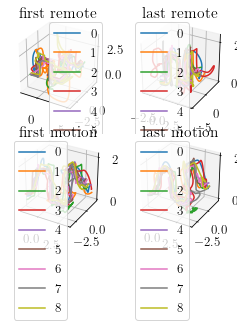

In [12]:
mpl.rcParams.update(params)

plt.figure()

for idx,i in enumerate(fields):
    ax = plt.subplot(2, 2, 1+idx, projection='3d')
    for idx1,log in enumerate(logs[i]):
        ax.plot(log['dronePosition.x'],log['dronePosition.z'],log['dronePosition.y'], label = str(idx1))
    plt.legend()
    plt.title(fields[idx])

# Time analysis

first remote
[36.68891906738281, 73.68862915039062, 39.73820495605469, 39.23795127868652, 94.03952026367188, 74.08895683288574, 57.13888931274414, 49.789329528808594, 77.23839950561523]
mean =  60.18319998847114
std =  19.26101363267273

last remote
[25.53936767578125, 29.975521087646484, 25.188079833984375, 48.438262939453125, 50.988128662109375, 63.9388427734375, 38.138580322265625, 32.87721252441406, 59.626495361328125]
mean =  41.63449902004666
std =  13.78146303850499

first motion
[26.73883819580078, 47.487369537353516, 52.7387809753418, 37.28846740722656, 54.826730728149414, 61.58778953552246, 51.0882511138916, 51.13821887969971, 58.23855209350586]
mean =  49.01477760738797
std =  10.196245186281294

last motion
[18.48773193359375, 42.438934326171875, 55.088836669921875, 34.08905029296875, 39.787872314453125, 53.738616943359375, 56.83905029296875, 36.73876953125, 35.638214111328125]
mean =  41.427452935112846
std =  11.618992155139125


first remote last remote
Kruskal
p = 0.046

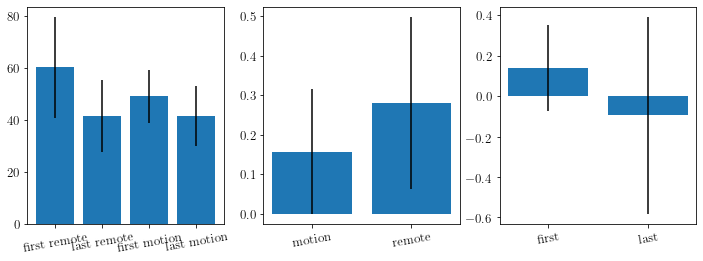

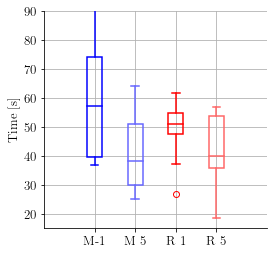

In [41]:
def compTime(df):
    return df['absoluteTime'].iloc[-1] - df['absoluteTime'].iloc[0]
time = runBasicAnalysis(compTime)
basic_plot(time)

basic_box(time, fields, y = 'Time [s]', ylim = [15,90], save = True, where = 'Time.pdf')

## <span style="color:red">Time significatively improves from first to last trial with remote</span>.

# Distance Analysis

first remote
[22.324165494490163, 47.55272516313187, 27.296154193201396, 26.429951555178604, 23.59043715530307, 26.766195403641024, 28.819758429636657, 22.411877011676065, 37.13760414983424]
mean =  29.147652061788122
std =  7.760241352642701

last remote
[16.300804799333633, 18.913434669361628, 16.521486751991354, 39.33784439306216, 17.505522909543476, 21.627921471488406, 19.671156363529324, 26.494663735001417, 21.808760102751325]
mean =  22.020177244006973
std =  6.820067262716887

first motion
[15.98972282475311, 19.1777130764286, 22.31855332241707, 17.96494570721543, 16.363344621467206, 16.809082127723983, 17.90026799383409, 16.644707575850145, 19.494031178687354]
mean =  18.073596492041887
std =  1.8916901736698728

last motion
[13.31047505639871, 18.91328878255961, 25.94867135780242, 22.021034077629242, 15.301398107391059, 16.013081638542097, 18.498482054697696, 20.48739833485118, 15.458738723781288]
mean =  18.439174237072592
std =  3.720273382565281


first remote last remote
K

/Users/lis/anaconda3/envs/bidir/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/lis/anaconda3/envs/bidir/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/lis/anaconda3/envs/bidir/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

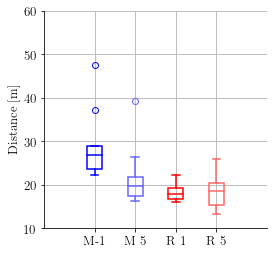

In [42]:
def compDist(df):
    
    steps = 10
    
    df['dronePositionFiltered.x'] = running_average(df['dronePosition.x'].values, steps)
    df['dronePositionFiltered.y'] = running_average(df['dronePosition.y'].values, steps)
    df['dronePositionFiltered.z'] = running_average(df['dronePosition.z'].values, steps)
    
    x = df['dronePositionFiltered.x'].values
    y = df['dronePositionFiltered.y'].values
    z = df['dronePositionFiltered.z'].values

    dx = np.diff(x)
    dy = np.diff(y)
    dz = np.diff(z)

    dd = np.sqrt(dx**2+dy**2+dz**2)
    d = np.sum(dd)

    return d

dist = runBasicAnalysis(compDist)

ax = basic_box(dist, fields, y = 'Distance [m]', ylim = [10, 60], save = True, where = 'Distance.pdf')

## <span style="color:red">Distance is signficatively lower in the first run for the motion controller, than compensated with time</span>.

# Velocity Analysis

first remote
[0.6048814400906103, 0.6341347159495576, 0.6837602868147377, 0.6715884255602592, 0.24915828741993426, 0.3564514622938567, 0.5060106263899103, 0.4493126763989051, 0.47349571494404086]
mean =  0.5143104039846458
std =  0.14031517590863443

last remote
[0.645198148003594, 0.635482840516, 0.6588149829340826, 0.8013585478356915, 0.33589714666761533, 0.33931569435189307, 0.5085288287248177, 0.7898589029202127, 0.354552401349232]
mean =  0.5632230548114598
std =  0.1755935978670183

first motion
[0.5914655502685631, 0.3966098525935303, 0.42224456411118905, 0.4696252298017714, 0.2991898834986133, 0.26814663326859206, 0.342798400128234, 0.3230888208583262, 0.33652588395147487]
mean =  0.3832994242755883
std =  0.09443820204604729

last motion
[0.7082632927919577, 0.4466226105355526, 0.47096298796043873, 0.625612682187399, 0.3839282141175893, 0.29544490800563034, 0.3226276545085635, 0.5557734657423912, 0.4253860700249964]
mean =  0.4705135428749465
std =  0.12930312815332673


first

/Users/lis/anaconda3/envs/bidir/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/lis/anaconda3/envs/bidir/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/lis/anaconda3/envs/bidir/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

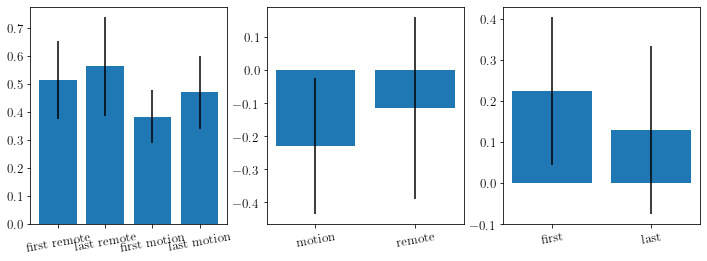

In [15]:
def compVel(df):
    x = df['dronePositionFiltered.x'].values
    y = df['dronePositionFiltered.y'].values
    z = df['dronePositionFiltered.z'].values
    t = df['absoluteTime'].values

    dx = np.diff(x)
    dy = np.diff(y)
    dz = np.diff(z)
    dt = np.diff(t)
    
    vx = np.append([0],dx/dt)
    vy = np.append([0],dy/dt)
    vz = np.append([0],dz/dt)
    
    df['droneVelocity.x'] = vx
    df['droneVelocity.y'] = vy
    df['droneVelocity.z'] = vz
    
    steps = 20    
    
    df['droneVelocityFiltered.x'] = running_average(df['droneVelocity.x'], steps)
    df['droneVelocityFiltered.y'] = running_average(df['droneVelocity.y'], steps)
    df['droneVelocityFiltered.z'] = running_average(df['droneVelocity.z'], steps)

    dv = np.sqrt(df['droneVelocityFiltered.x'][100:]**2+df['droneVelocityFiltered.y'][100:]**2+df['droneVelocityFiltered.z'][100:]**2)
    
    v = np.mean(dv)
    
    return v

vel = runBasicAnalysis(compVel)
basic_plot(vel)

# Acceleration Analysis

first remote
[0.8179730420974849, 0.6890353640729231, 0.87104228422705, 0.8843567576521152, 0.2712746642485197, 0.4877454520288943, 0.606891666005453, 0.5515010879218111, 0.5596204661505985]
mean =  0.6377156427116499
std =  0.18904778274406048

last remote
[0.7457047362862306, 0.7660319311546149, 0.7721134977606467, 0.9817429323651226, 0.36787722388214456, 0.4521359256637946, 0.6252243581723516, 1.0243986643935286, 0.4324860642361804]
mean =  0.6853017037682906
std =  0.22191488603631718

first motion
[0.6262592333715965, 0.5009339545325944, 0.8170690847522056, 0.6014993422071747, 0.6339664852885869, 0.4363224994296056, 0.6428538751267902, 0.5634635091197591, 0.34400076110007966]
mean =  0.5740409716587103
std =  0.12832729437072993

last motion
[0.6935333493624882, 0.5515874714924929, 0.911646071893495, 1.0202026105814126, 0.7105799614817411, 0.5422221599843919, 0.5412648713853637, 0.9994129873101419, 0.43387623212663523]
mean =  0.7115917461797958
std =  0.20517070691457476


first 

/Users/lis/anaconda3/envs/bidir/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/lis/anaconda3/envs/bidir/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/lis/anaconda3/envs/bidir/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

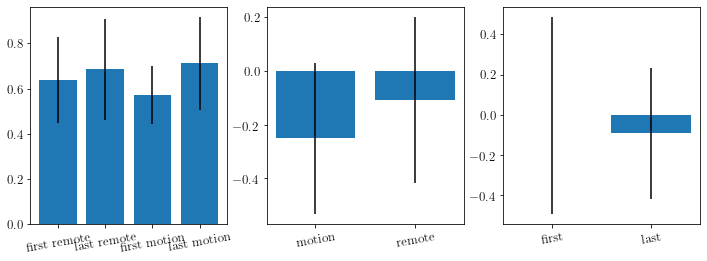

In [16]:
def compAcc(df):
    vx = df['droneVelocityFiltered.x'].values
    vy = df['droneVelocityFiltered.y'].values
    vz = df['droneVelocityFiltered.z'].values
    t = df['absoluteTime'].values
    
    dvx = np.diff(vx)
    dvy = np.diff(vy)
    dvz = np.diff(vz)
    dt = np.diff(t)
    
    ax = np.append([0],dvx/dt)
    ay = np.append([0],dvy/dt)
    az = np.append([0],dvz/dt)
    
    df['droneAcceleration.x'] = ax
    df['droneAcceleration.y'] = ay
    df['droneAcceleration.z'] = az
    
    steps = 30    
    
    df['droneAccelerationFiltered.x'] = running_average(df['droneAcceleration.x'], steps)
    df['droneAccelerationFiltered.y'] = running_average(df['droneAcceleration.y'], steps)
    df['droneAccelerationFiltered.z'] = running_average(df['droneAcceleration.z'], steps)

    da = np.sqrt(df['droneAccelerationFiltered.x'][100:]**2+df['droneAccelerationFiltered.y'][100:]**2+df['droneAccelerationFiltered.z'][100:]**2)
    
    a = np.mean(da)

    return a

acc = runBasicAnalysis(compAcc)
basic_plot(acc)

# Jerk Analysis

first remote
[1.7101052294816639, 1.2158228418982926, 1.759313586063058, 1.726223532960491, 0.574171264364218, 0.9836955495754648, 1.1482867583882286, 1.113160929116499, 1.0043641604774616]
mean =  1.248349316925042
std =  0.3824046112807294

last remote
[1.5538321319313084, 1.5457041607177497, 1.61463918370713, 1.826863924945043, 0.8415444930858282, 0.9506634557176598, 1.275919056220123, 2.0065321167916434, 0.8193883394608696]
mean =  1.3816763180641507
std =  0.40883548360396527

first motion
[1.322450539991678, 1.1647612441273885, 2.267610592462352, 1.2805465811439398, 1.9504241331184142, 1.1497659673238672, 1.6717749738185856, 1.5655025750472022, 0.6987563484567377]
mean =  1.452399217276685
std =  0.44249752588135216

last motion
[1.294368628816663, 1.188418081046969, 2.440149225828725, 2.239030378255799, 2.0569458134272276, 1.546473452050761, 1.3644658022080893, 2.657912206904177, 0.8842246116743919]
mean =  1.741332022245867
std =  0.5865058172079529


first remote last remote
K

/Users/lis/anaconda3/envs/bidir/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/lis/anaconda3/envs/bidir/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/lis/anaconda3/envs/bidir/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

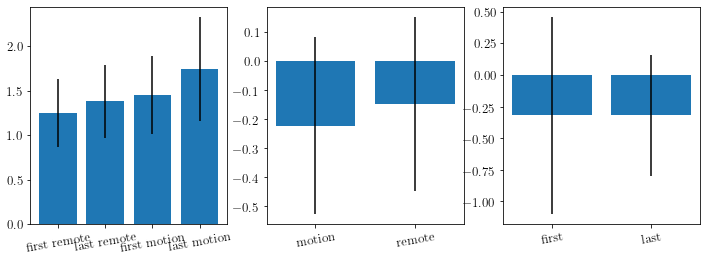

In [17]:
def compJerk(df):
    ax = df['droneAccelerationFiltered.x'].values
    ay = df['droneAccelerationFiltered.y'].values
    az = df['droneAccelerationFiltered.z'].values
    t = df['absoluteTime'].values
    
    dax = np.diff(ax)
    day = np.diff(ay)
    daz = np.diff(az)
    dt = np.diff(t)
    
    jx = np.append([0],dax/dt)
    jy = np.append([0],day/dt)
    jz = np.append([0],daz/dt)
    
    df['droneJerk.x'] = jx
    df['droneJerk.y'] = jy
    df['droneJerk.z'] = jz
    
    steps = 40    
    
    df['droneJerkFiltered.x'] = running_average(df['droneJerk.x'], steps)
    df['droneJerkFiltered.y'] = running_average(df['droneJerk.y'], steps)
    df['droneJerkFiltered.z'] = running_average(df['droneJerk.z'], steps)

    dj = np.sqrt(df['droneJerkFiltered.x'][100:]**2+df['droneJerkFiltered.y'][100:]**2+df['droneJerkFiltered.z'][100:]**2)
    
    
    j = np.mean(dj)

    return j

jerk = runBasicAnalysis(compJerk)
basic_plot(jerk)

# Energy Analysis

first remote
[0.5259177134846239, 0.4944717823852506, 0.6579803974053456, 0.6554333726698613, 0.18596139264175648, 0.29068388706730974, 0.4952198825940615, 0.40532866930662886, 0.41502272963225756]
mean =  0.4584466474652329
std =  0.1464087229132558

last remote
[0.5756474399999127, 0.5297628936655865, 0.6032270083944953, 0.78568159326976, 0.27143051199773327, 0.2941524855958804, 0.4320474092364968, 0.7541072597735138, 0.2967278049225691]
mean =  0.5047538229839943
std =  0.1837267333421183

first motion
[0.5792481703931225, 0.40264210113732446, 0.4229137360655344, 0.5021803665451635, 0.2949968753521782, 0.2749768842952496, 0.3498574962024828, 0.329681759145101, 0.321776954562095]
mean =  0.3864749270775835
std =  0.09527189843658464

last motion
[0.6470979471422356, 0.46277282717205676, 0.5455400413508689, 0.6862370511422009, 0.3710689084353053, 0.3057343872266924, 0.33103951113313274, 0.7095046083473078, 0.4046276050753439]
mean =  0.4959580985583493
std =  0.14739698716882976


fir

/Users/lis/anaconda3/envs/bidir/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


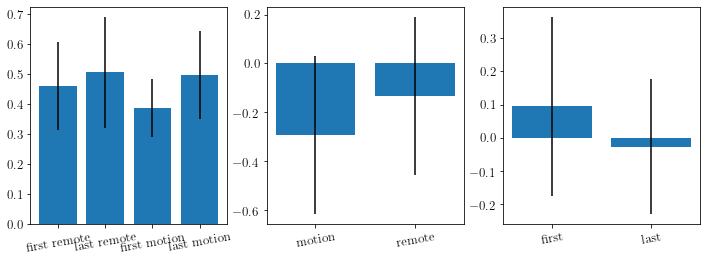

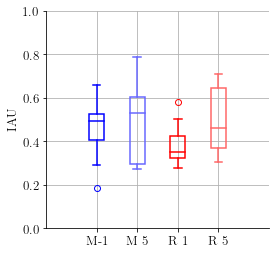

In [43]:
def compEnergy(df):
    df['controlInput'] = np.sqrt(df['controlSpeed.x']**2+df['controlSpeed.y']**2+df['controlSpeed.z']**2)
    return df['controlInput'].mean()

energy = runBasicAnalysis(compEnergy)
basic_plot(energy)

basic_box(energy, fields, y = 'IAU', ylim = [0,1], save = True, where = 'IAU.pdf')

## <span style="color:red">Energy is signficatively lower in the first run for the motion controller, than compensated with time</span>.

# Collision Analysis

In [19]:
coll_df = pd.read_csv('/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/Learning_Curve/Bidir - learning collisions - Sheet1.csv')

In [20]:
coll = {}

coll['motion'] = coll_df[coll_df['Interface']=='Motion']
coll['remote'] = coll_df[coll_df['Interface']=='Remote']


coll['first motion'] = coll['motion'][coll['motion']['Run']==1]
coll['last motion'] = coll['motion'][coll['motion']['Run']==5]
coll['first remote'] = coll['remote'][coll['remote']['Run']==1]
coll['last remote'] = coll['remote'][coll['remote']['Run']==5]


consider all runs

mean motion =  0.7
std motion =  0.9529760045804524
mean remote =  1.04
std remote =  1.497753419666418

total motion =  35
total remote =  52

p = 0.3307919461014416

consider first runs

mean motion =  0.9
std motion =  0.9944289260117534
mean remote =  0.7
std remote =  0.9486832980505138

total motion =  9
total remote =  7

p = 0.640316414374904

consider last runs

mean motion =  0.9
std motion =  1.1005049346146119
mean remote =  1.7
std remote =  1.70293863659264

total motion =  9
total remote =  17

p = 0.3901157668035834

FIRST LAST REMOTE

p = 0.20392477458611555


Text(0.5, 1.0, 'Collisions - last run')

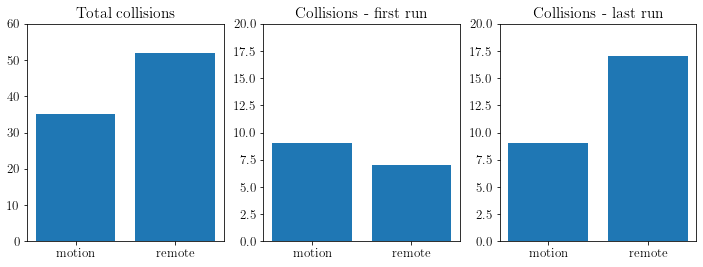

In [21]:
def compute_mean_std_collisions(data_m, data_r):
    mean_m = data_m['Collisions'].mean()
    std_m = data_m['Collisions'].std()
    mean_r = data_r['Collisions'].mean()
    std_r = data_r['Collisions'].std()

    print('mean motion = ', mean_m)
    print('std motion = ', std_m)
    print('mean remote = ', mean_r)
    print('std remote = ', std_r)
    print('')
    print('total motion = ', data_m['Collisions'].sum())
    print('total remote = ', data_r['Collisions'].sum())
    print('')

    t, p = t_test_kruskal(data_m['Collisions'],data_r['Collisions'])

    print_p(p)
    
print('')
print('consider all runs')
print('')
compute_mean_std_collisions(coll['motion'], coll['remote'])
    
print('')
print('consider first runs')
print('')
compute_mean_std_collisions(coll['first motion'], coll['first remote'])
    
print('')
print('consider last runs')
print('')
compute_mean_std_collisions(coll['last motion'], coll['last remote'])

t, p = t_test_kruskal(coll['first remote']['Collisions'],coll['last remote']['Collisions'])

print('')
print('FIRST LAST REMOTE')
print('')
print_p(p)


    
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(131)
ax.bar([0, 1],
   [coll['motion']['Collisions'].sum(), coll['remote']['Collisions'].sum()])

plt.xticks(range(2), ['motion', 'remote'])
plt.ylim([0, 60])
plt.title('Total collisions')

ax = fig.add_subplot(132)
ax.bar([0, 1],
   [coll['first motion']['Collisions'].sum(), coll['first remote']['Collisions'].sum()])

plt.xticks(range(2), ['motion', 'remote'])
plt.ylim([0, 20])
plt.title('Collisions - first run')

ax = fig.add_subplot(133)
ax.bar([0, 1],
   [coll['last motion']['Collisions'].sum(), coll['last remote']['Collisions'].sum()])

plt.xticks(range(2), ['motion', 'remote'])
plt.ylim([0, 20])
plt.title('Total collisions')
plt.title('Collisions - last run')